In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
import torch

class MultinomialSyntheticDataGenerator(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None):
        """
        A custom estimator for generating synthetic data using multinomial logistic regression,
        with the feature distribution inferred from the training data.
        
        Parameters:
        - n_samples (int): Number of synthetic samples to generate.
        - random_state (int): Seed for reproducibility.
        """
        self.random_state = random_state
        np.random.seed(self.random_state)


    def fit(self, X, y):
        """
        Fits a multinomial logistic regression model to the data and estimates the feature distribution.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        - y (ndarray): Target labels of shape (n_samples,).
        
        Returns:
        - self: The fitted instance.
        """
        # Store mean and covariance of features
        self.classes_ = np.unique(y)
        self.feature_mean_ = np.mean(X, axis=0)
        self.feature_cov_ = np.cov(X, rowvar=False)
        
        # Fit a logistic regression model
        self.model_ = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=self.random_state)
        self.model_.fit(X, y)
        
        # Store the number of classes and features
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        return self

    def predict_proba(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict_proba(X)
    

    def predict(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict(X)

    def generate(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        if self.n_features_ == 1:
            X_synthetic = np.random.normal(self.feature_mean_, self.feature_cov_, n).reshape(-1, 1)
        else:
            X_synthetic = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        
        # Compute class probabilities
        P_Y_given_X = self.predict_proba(X_synthetic)
        
        # Sample synthetic labels
        y_synthetic = np.array([np.random.choice(self.n_classes_, p=probs) for probs in P_Y_given_X])
        
        return X_synthetic, y_synthetic


    def generate_instances(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        
        if self.n_features_ == 1:
            X = np.random.normal(self.feature_mean_, self.feature_cov_, n).reshape(-1, 1)
        else:
            X = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        return X



In [2]:
class OracleAnnotator:
    def __init__(self,mapie_clf, generator):
        self.mapie_clf = mapie_clf
        self.classes_ = mapie_clf.classes_
        self.generator = generator

    def generate_pairs_in_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        X = self.generator.generate_instances(n)
        X = np.repeat(X, repeats=2, axis=0)

        y = np.hstack([np.random.choice(self.classes_, size=2, replace=False) for _ in range(n)])

        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)
        return X_pairs, y_pairs


    def generate_pairs_cross_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs
    
    # def create_pairs_for_classification_data(self, X):
    #     """
    #     Generates synthetic data and labels based on the learned model and feature distribution.
        
    #     Returns:
    #     - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
    #     - y_synthetic (ndarray): Generated labels of shape (n_samples,).
    #     """
    #     # Generate synthetic features based on the inferred distribution
        
    #     X = self.generator.generate_instances(2*n)
    #     y = np.random.choice(self.classes_, size=2*n, replace=True)
    #     conformities = self.get_conformity(X,y)

    #     X_rs = X.reshape(n,2,self.generator.n_features_)
    #     y_rs = y.reshape(n,2)
    #     conformities_n_rs = - conformities.reshape(n,2)
    #     sort_idx = conformities_n_rs.argsort(axis=1)
    #     X_rs[sort_idx]
    #     y_rs[sort_idx,:]
    #     X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
    #     y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.mapie_clf.estimator.predict_proba(X)
        scores = self.mapie_clf.conformity_score_function_.get_conformity_scores(
                        y, y_pred_proba, y_enc=y
                    )
        return scores

In [3]:
def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

In [4]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch

def conduct_oracle_experiment(conformity_score, num_instances_to_check, generator, X_cal, y_cal):
    tau_corrs = []
    gamma_corrs = []
    # Generate a small dataset

    mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
    # create mapie classifier for conformity scores
    mapie_clf.fit(X_cal, y_cal)
    # create 
    oracle_annotator = OracleAnnotator(mapie_clf, generator)
    models = []

    for num_instances in num_instances_to_check:
        X_train = generator.generate_instances(num_instances).repeat(3, axis=0)
        y_train = np.tile(generator.classes_, num_instances)
        conformities = oracle_annotator.get_conformity(X_train,y_train)
        sort_idx = (-conformities).argsort(axis=0).flatten()

        X_sorted = X_train[sort_idx]
        y_sorted = y_train[sort_idx]

        X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
        y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
        y_pairs = np.expand_dims(y_pairs,axis=-1)


        ds = LabelPairDataset()
        ds.create_from_numpy_pairs(X_pairs, y_pairs)
        pair_loader = DataLoader(ds, batch_size=64)
        ds_val = LabelPairDataset()
        ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
        val_loader = DataLoader(ds_val, batch_size=64)
        print(len(ds))
        model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
        model.num_classes = generator.n_classes_
        device = next(model.parameters()).device
        print(f"Model is on: {device}")
        model._fit(pair_loader, val_loader=pair_loader, num_epochs=300, learning_rate=0.01, patience=100, verbose=True)

        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test = generator.generate_instances(100).repeat(3, axis=0)
        y_test = np.tile(generator.classes_, 100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
        conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
        gamma_corr = goodman_kruskal_gamma(skills_from_model,conformity_scores)
        gamma_corrs.append(gamma_corr)
        models.append(models)
    return tau_corrs, gamma_corrs, skills_from_model, conformity_scores, models

In [5]:
num_instances_to_check = np.linspace(10,100,5).astype(int)
X_train, y_train = make_classification(
    n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
)

# Initialize and fit the generator
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_train, y_train)
X_cal, y_cal = generator.generate(n=100)
tau_corrs_LAC, gamma_corrs_LAC, skills_LAC, conformities_LAC, models_LAC = conduct_oracle_experiment(LACConformityScore(), num_instances_to_check, generator, X_cal, y_cal)
tau_corrs_APS, gamma_corrs_APS, skills_APC, conformities_APC, models_APC = conduct_oracle_experiment(APSConformityScore(), num_instances_to_check, generator, X_cal, y_cal)
# tau_corrs_TopK, skills_TopK, conformities_TopK, models_TopK = conduct_oracle_experiment(TopKConformityScore(), num_instances_to_check, generator, X_cal, y_cal)
# tau_corrs_Naive, skills_Naive, conformities_Naive = conduct_oracle_experiment(NaiveConformityScore(), num_pairs_to_check, generator, X_cal, y_cal)

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


435
Model is on: cpu
Epoch 1/300
  Train Loss: 0.0995
  Val Loss: 0.0986
Epoch 2/300
  Train Loss: 0.0984
  Val Loss: 0.0980
Epoch 3/300
  Train Loss: 0.0979
  Val Loss: 0.0976
Epoch 4/300
  Train Loss: 0.0976
  Val Loss: 0.0974
Epoch 5/300
  Train Loss: 0.0974
  Val Loss: 0.0973
Epoch 6/300
  Train Loss: 0.0974
  Val Loss: 0.0973
Epoch 7/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 8/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 9/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 10/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 11/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 12/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 13/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 14/300
  Train Loss: 0.0973
  Val Loss: 0.0972
Epoch 15/300
  Train Loss: 0.0972
  Val Loss: 0.0971
Epoch 16/300
  Train Loss: 0.0972
  Val Loss: 0.0971
Epoch 17/300
  Train Loss: 0.0972
  Val Loss: 0.0971
Epoch 18/300
  Train Loss: 0.0971
  Val Loss: 0.0970
Epoch 19/300
  Train Loss: 0.0971


KeyboardInterrupt: 

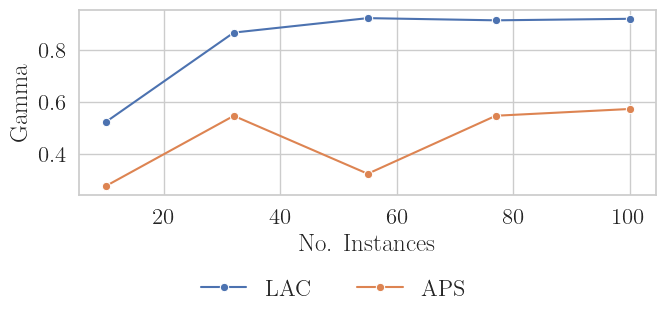

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Gamma")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
sns.lineplot(x=num_instances_to_check, y=gamma_corrs_LAC, ax = ax, marker="o",label="LAC", legend=False)
sns.lineplot(x=num_instances_to_check, y=gamma_corrs_APS, ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_TopK, ax = ax, marker="o", label="TopK", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [120]:
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=APSConformityScore())
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)
models = []

X_train = generator.generate_instances(30).repeat(3, axis=0)
y_train = np.tile(generator.classes_, 30)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs,axis=-1)

model = models_APS[-1]

ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
pair_loader = DataLoader(ds, batch_size=64)
ds_val = LabelPairDataset()
ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
val_loader = DataLoader(ds_val, batch_size=64)
print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
model.num_classes = generator.n_classes_
device = next(model.parameters()).device
print(f"Model is on: {device}")
# model._fit(pair_loader, val_loader=pair_loader, num_epochs=300, learning_rate=0.01, patience=100, verbose=True)

# generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
X_test = generator.generate_instances(100).repeat(3, axis=0)
y_test = np.tile(generator.classes_, 100)      
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
fig, ax = plt.subplots()
ax.scatter(skills_from_model, conformity_scores)
ax.set_xlabel("learn utility")
ax.set_ylabel("conformity score")

NameError: name 'models_APS' is not defined

In [89]:
X_seed, y_seed = make_classification(n_samples=1000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
conformity_score = APSConformityScore()
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

# generate all possible pairs for a couple of instances
n_instances = 30
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)


ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
for x,y in ds:
    print(x,y)
print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(),torch.nn.Sigmoid(),torch.nn.Sigmoid()], output_dim=len(generator.classes_))

pair_loader = DataLoader(ds, batch_size=32)
val_loader = DataLoader(ds, batch_size=32)
model.num_classes = generator.n_classes_
model._fit(pair_loader, val_loader=val_loader, num_epochs=250, patience=250, learning_rate=0.01, verbose=True)


# # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
# X_test, y_test = X_train, y_train
# conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
# skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
# tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
# print("in-sample: ", tau_corr)
# X_test, y_test = generator.generate(n=10)
# conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
# skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
# tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
# print("out-of-sample: ", tau_corr)


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


tensor([[ 0.7208,  0.5163, -0.6309],
        [-1.3913,  2.5045,  1.7749]]) tensor([[2],
        [2]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-1.0674,  1.3281,  0.4627]]) tensor([[2],
        [2]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-0.1633,  0.4704,  1.8518]]) tensor([[2],
        [0]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-0.9371, -0.4074, -1.4437]]) tensor([[2],
        [1]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-0.8381, -0.1507, -1.9040]]) tensor([[2],
        [1]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-0.7658, -0.9277, -0.1292]]) tensor([[2],
        [0]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-2.2594,  1.9810,  0.6624]]) tensor([[2],
        [2]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-1.5482,  2.5376,  3.2692]]) tensor([[2],
        [2]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-0.4154, -0.4283, -1.0326]]) tensor([[2],
        [1]])
tensor([[ 0.7208,  0.5163, -0.6309],
        [-0.4558, -1.1577, -0.1511]]) tensor(

In [117]:
# X_test, y_test = X_train, y_train
X_test = generator.generate_instances(100).repeat(3, axis=0)
y_test = np.tile(generator.classes_, 100)   


conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)

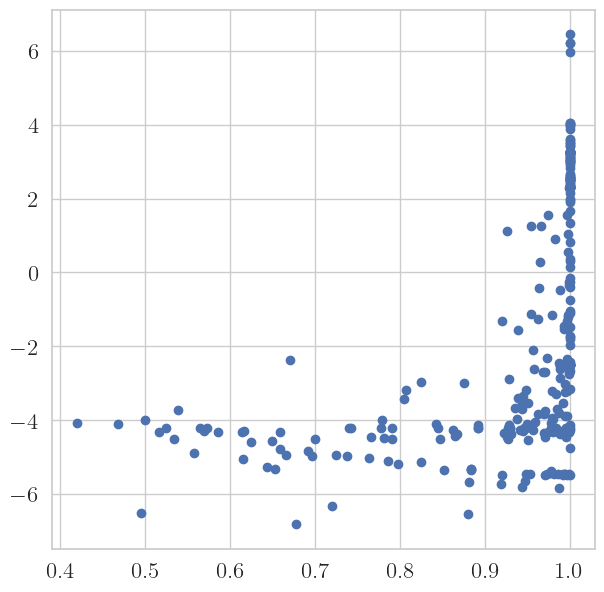

In [118]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)

plt.scatter(conformity_scores, skills_from_model)

In [119]:
goodman_kruskal_gamma(conformity_scores, skills_from_model)
# kendalltau(conformity_scores, skills_from_model)

0.5720758118461939

In [14]:
n_instances = 10
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)
ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
for x,y in ds:
    print(x,y)
pair_loader = DataLoader(ds, batch_size=32)
# ds_val = LabelPairDataset()
# ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
# val_loader = DataLoader(ds_val, batch_size=32, num_workers=6)
# print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), SortLayer(),torch.nn.Identity()], output_dim=len(generator.classes_))
model.num_classes = generator.n_classes_
print(len(pair_loader))
# device = next(model.parameters()).device
# print(f"Model is on: {device}")
model._fit(pair_loader, val_loader=pair_loader, num_epochs=250, learning_rate=0.001, verbose=True)


# # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
# X_test, y_test = generator.generate(n=100)
# skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
# conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
# tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)


ValueError: cov must be 2 dimensional and square

In [25]:
from mapie.classification import MapieClassifier
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=TopKConformityScore())
# create mapie classifier for conformity scores
mapie_clf.fit(X_train, y_train)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

In [13]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch
X_seed, y_seed = make_classification(n_samples=1000, n_features=1, n_classes=3, n_informative=1, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42)
conformity_score = APSConformityScore()
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)
mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

# generate all possible pairs for a couple of instances
n_instances = 10
n_classes = len(generator.classes_)
n_obs = n_instances * n_classes
X_train = generator.generate_instances(n_instances).repeat(n_classes, axis=0)
y_train = np.tile(generator.classes_, n_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]
conformities_sorted = conformities[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs, axis=-1)


ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
for x,y in ds:
    print(x,y)
print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), SortLayer(),torch.nn.Identity()], output_dim=len(generator.classes_))

pair_loader = DataLoader(ds, batch_size=32)
model.num_classes = generator.n_classes_
model._fit(pair_loader, val_loader=pair_loader, num_epochs=250, learning_rate=0.001, verbose=True)


ValueError: n_classes(3) * n_clusters_per_class(1) must be smaller or equal 2**n_informative(1)=2

In [ ]:
X_seed, y_seed = make_classification(100,n_informative=1,n_classes=3)
generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)

num_instances = 30

mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=APSConformityScore())
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

X_train = generator.generate_instances(num_instances).repeat(3, axis=0)
y_train = np.tile(generator.classes_, num_instances)
conformities = oracle_annotator.get_conformity(X_train,y_train)
sort_idx = (-conformities).argsort(axis=0).flatten()

X_sorted = X_train[sort_idx]
y_sorted = y_train[sort_idx]

X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
y_pairs = np.expand_dims(y_pairs,axis=-1)


ds = LabelPairDataset()
ds.create_from_numpy_pairs(X_pairs, y_pairs)
pair_loader = DataLoader(ds, batch_size=64)
ds_val = LabelPairDataset()
ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
val_loader = DataLoader(ds_val, batch_size=64)
print(len(ds))
model = LabelRankingModel(input_dim=generator.n_features_, hidden_dims=3*[generator.n_features_], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
model.num_classes = generator.n_classes_
device = next(model.parameters()).device
print(f"Model is on: {device}")
model._fit(pair_loader, val_loader=pair_loader, num_epochs=300, learning_rate=0.01, patience=100, verbose=True)

# generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
X_test = generator.generate_instances(100).repeat(3, axis=0)
y_test = np.tile(generator.classes_, 100)      
skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


4005
Model is on: cpu
Epoch 1/300
  Train Loss: 0.0114
  Val Loss: 0.0109
Epoch 2/300
  Train Loss: 0.0110
  Val Loss: 0.0101
Epoch 3/300
  Train Loss: 0.0096
  Val Loss: 0.0082
Epoch 4/300
  Train Loss: 0.0081
  Val Loss: 0.0069
Epoch 5/300
  Train Loss: 0.0069
  Val Loss: 0.0057
Epoch 6/300
  Train Loss: 0.0059
  Val Loss: 0.0050
Epoch 7/300
  Train Loss: 0.0053
  Val Loss: 0.0046
Epoch 8/300
  Train Loss: 0.0050
  Val Loss: 0.0043
Epoch 9/300
  Train Loss: 0.0046
  Val Loss: 0.0041
Epoch 10/300
  Train Loss: 0.0043
  Val Loss: 0.0039
Epoch 11/300
  Train Loss: 0.0041
  Val Loss: 0.0037
Epoch 12/300
  Train Loss: 0.0039
  Val Loss: 0.0036
Epoch 13/300
  Train Loss: 0.0039
  Val Loss: 0.0036
Epoch 14/300
  Train Loss: 0.0038
  Val Loss: 0.0035
Epoch 15/300
  Train Loss: 0.0037
  Val Loss: 0.0035
Epoch 16/300
  Train Loss: 0.0037
  Val Loss: 0.0034
Epoch 17/300
  Train Loss: 0.0036
  Val Loss: 0.0034
Epoch 18/300
  Train Loss: 0.0036
  Val Loss: 0.0033
Epoch 19/300
  Train Loss: 0.0035

In [ ]:
np.random.seed(42)
class_1 = np.random.normal(loc=1, scale=0.5, size=100)
class_2 = np.random.normal(loc=3, scale=0.5, size=100)
class_3 = np.random.normal(loc=5, scale=0.5, size=100)

# Combine into one dataset
X_seed = np.concatenate([class_1, class_2]).reshape(-1,1)
y_seed = np.concatenate([np.zeros(100), np.ones(100)])


generator = MultinomialSyntheticDataGenerator(random_state=42)
generator.fit(X_seed, y_seed)
X_cal, y_cal = generator.generate(n=100)

num_instances = 30

mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=APSConformityScore())
# create mapie classifier for conformity scores
mapie_clf.fit(X_cal, y_cal)
# create 
oracle_annotator = OracleAnnotator(mapie_clf, generator)

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


ValueError: Invalid method for binary target. Your target is not of type multiclass and allowed values for binary type are ['score', 'lac'].

In [53]:
X,y = generator.generate(20)

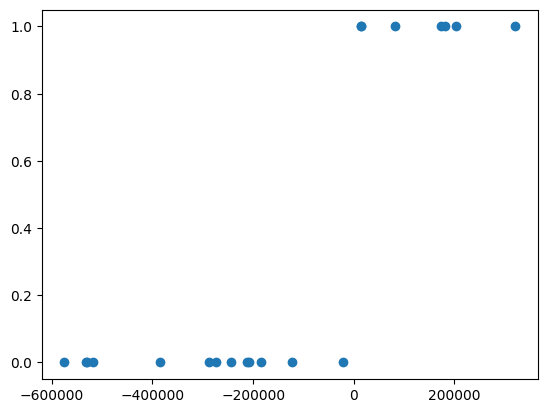

In [54]:
plt.scatter(X.flatten(), y)

In [36]:
import torch
def _sort_sum(probs):
        """
        Sort probabilities and calculate cumulative sum.

        Args:
            probs (torch.Tensor): The prediction probabilities.

        Returns:
            tuple: A tuple containing:
                - indices (torch.Tensor): The rank of ordered probabilities in descending order.
                - ordered (torch.Tensor): The ordered probabilities in descending order.
                - cumsum (torch.Tensor): The accumulation of sorted probabilities.
        """
        ordered, indices = torch.sort(probs, dim=-1, descending=True)
        cumsum = torch.cumsum(ordered, dim=-1)
        return indices, ordered, cumsum

def _calculate_single_label(probs, label):
    """
    Calculate non-conformity score for a single label.

    Args:
        probs (torch.Tensor): The prediction probabilities.
        label (torch.Tensor): The ground truth label.

    Returns:
        torch.Tensor: The non-conformity score for the given label.
    """
    indices, ordered, cumsum = _sort_sum(probs)
    U = torch.zeros(indices.shape[0], device=probs.device)

    idx = torch.where(indices == label.view(-1, 1))
    scores = cumsum[idx] - U * ordered[idx]
    return scores

def get_conformity(clf, X, y):
    y_pred_proba = clf.predict_proba(X)
    
    scores = _calculate_single_label(torch.tensor(y_pred_proba),torch.tensor(y))
    return scores



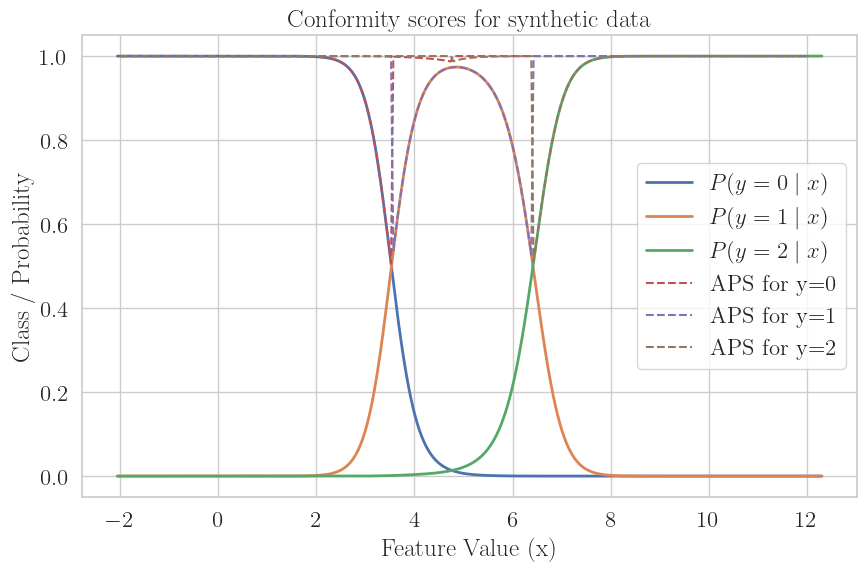

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 2)

# Step 1: Define class parameters
class_params = {
    0: {"mean": 2, "std": 1, "prior": 0.3},
    1: {"mean": 5, "std": 0.8, "prior": 0.4},
    2: {"mean": 8, "std": 1.2, "prior": 0.3},
}

# Step 2: Create an instance of the classifier
clf = GaussianSyntheticClassifier(class_params=class_params)

# Step 3: Generate synthetic data
X, y = clf.generate_data(n_samples=1000)

# Step 4: Fit the classifier (it's effectively a no-op, but we call it for sklearn compatibility)
clf.fit(X, y)

# Step 5: Predict probabilities for a range of x values (for plotting)
x_range = np.linspace(X.min() - 1, X.max() + 1, 1000)
probs = clf.predict_proba(x_range)

# Step 6: Plot the data and probabilities
plt.figure(figsize=(10, 6))

# Scatter plot of the synthetic data
# plt.scatter(X, y + np.random.uniform(-0.1, 0.1, len(y)), c=y, cmap='viridis', alpha=0.6, edgecolor='k', label='Data')

# Plot the probabilities for each class
for i, c in enumerate(clf.classes_):
    plt.plot(x_range, probs[:, i], label=rf'$P(y={c} \mid x)$', linewidth=2)

X_nc = np.linspace(-2,12,300).reshape(-1,1)
y_0  = np.full((300),0)
y_1  = np.full((300),1)
y_2  = np.full((300),2)
y_0_nc = get_conformity(clf,X_nc,y_0).detach().cpu().numpy()
y_1_nc = get_conformity(clf,X_nc,y_1).detach().cpu().numpy()
y_2_nc = get_conformity(clf,X_nc,y_2).detach().cpu().numpy()


plt.plot(X_nc.flatten(), y_0_nc, linestyle="--", label="APS for y=0")
plt.plot(X_nc.flatten(), y_1_nc, linestyle="--", label="APS for y=1")
plt.plot(X_nc.flatten(), y_2_nc, linestyle="--", label="APS for y=2")


# Labels and title
plt.title("Conformity scores for synthetic data")
plt.xlabel("Feature Value (x)")
plt.ylabel("Class / Probability")
plt.legend()
plt.show()